In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from sklearn.cluster import spectral_clustering
from scipy.sparse.csgraph import laplacian
from matplotlib.colors import to_rgba

Important: We need to reselect dataset to make sure each song appears at most once in a playlist (First merge genre in each playlist, then select playlists with over 20 songs); we should edit the ppt too after we finalize our dataset

In [2]:
df = pd.read_csv("playlists_filtered.csv")
display(df)

,Track URI,Track,Artist,Album,Duration,Genre,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Playlist,Pid
0,spotify:track:4pmc2AxSEq6g7hPVlJCPyP,"Jumpin', Jumpin'",Destiny's Child,The Writing's On The Wall,230200,"dance pop,girl group,pop,r&b,urban contemporary",0.771,0.685,1.0,-4.639,1.0,0.0567,0.005430,0.001570,0.0537,0.683,88.997,4.0,Throwbacks,0
1,spotify:track:1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,Shaggy,Hot Shot,227600,Hiphop,0.853,0.606,0.0,-4.596,1.0,0.0713,0.056100,0.000000,0.3130,0.654,189.518,4.0,Throwbacks,0
2,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott,The Cookbook,226864,Hiphop,0.904,0.813,4.0,-7.105,0.0,0.1210,0.031100,0.006970,0.0471,0.810,125.461,4.0,Throwbacks,0
3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Rock Your Body,Justin Timberlake,Justified,267267,Hiphop,0.891,0.714,4.0,-6.055,0.0,0.1400,0.202000,0.000234,0.0521,0.818,201.944,4.0,Throwbacks,0
4,spotify:track:5lDriBxJd22IhOH9zTcFrV,Dirty Little Secret,The All-American Rejects,Move Along,193653,Emo,0.465,0.954,10.0,-4.251,1.0,0.0440,0.000346,0.000005,0.5730,0.458,143.850,4.0,Throwbacks,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236447,spotify:track:6ZfXA2xakAvphXOSOJ3u1W,When I Look At You,Miley Cyrus,The Time Of Our Lives,248587,Emo,0.459,0.545,6.0,-4.874,1.0,0.0282,0.142000,0.000000,0.1050,0.194,137.941,3.0,Rainy days,27426
1236448,spotify:track:7LVHVU3tWfcxj5aiPFEW4Q,Fix You,Coldplay,X & Y,295533,Pop,0.209,0.417,3.0,-8.740,1.0,0.0338,0.164000,0.001960,0.1130,0.124,138.178,4.0,Rainy days,27426
1236449,spotify:track:1VdZ0vKfR5jneCmWIUAMxK,The A Team,Ed Sheeran,+,258373,Emo,0.642,0.289,9.0,-9.918,1.0,0.0367,0.669000,0.000000,0.1800,0.407,169.992,4.0,Rainy days,27426
1236450,spotify:track:6ybViy2qrO9sIi41EgRJgx,Don't Know Why,Norah Jones,Come Away With Me,186146,"contemporary vocal jazz,jazz pop,vocal jazz",0.732,0.198,5.0,-11.775,1.0,0.0280,0.883000,0.000011,0.0659,0.618,88.174,4.0,Rainy days,27426


Here I concatenate the same songs in each playlist on our current dataset

In [3]:
def concat_genre(df):
    columns_except_genre = [col for col in df.columns if col != 'Genre']
    df_concat = df.groupby(['Track URI']).agg({
        **{col: 'first' for col in columns_except_genre},
        'Genre': lambda x: ','.join(x.astype(str)),
    }).reset_index(drop = True)
    return df_concat

In [4]:
df_new = df.groupby(['Pid'], as_index = False).apply(concat_genre).reset_index(drop = True)

In [5]:
df_new

,Track URI,Track,Artist,Album,Duration,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Playlist,Pid,Genre
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott,The Cookbook,226864,0.904,0.813,4.0,-7.105,0.0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,4.0,Throwbacks,0,Hiphop
1,spotify:track:0uqPG793dkDDN7sCUJJIVC,Where Is The Love?,The Black Eyed Peas,Elephunk,272533,0.835,0.687,5.0,-3.180,1.0,0.1840,0.10100,0.000000,0.1320,0.828,188.118,4.0,Throwbacks,0,RnB
2,spotify:track:12qZHAeOyTf93YAWvGDTat,All The Small Things,blink-182,Enema Of The State,168000,0.442,0.893,0.0,-4.878,1.0,0.0505,0.00844,0.000000,0.5290,0.712,148.119,4.0,Throwbacks,0,"Emo,alternative metal,modern rock,pop punk,pun..."
3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Rock Your Body,Justin Timberlake,Justified,267267,0.891,0.714,4.0,-6.055,0.0,0.1400,0.20200,0.000234,0.0521,0.818,201.944,4.0,Throwbacks,0,"Hiphop,dance pop,pop"
4,spotify:track:1HwpWwa6bnqqRhK8agG4RS,Beautiful Soul,Jesse McCartney,Beautiful Soul,214227,0.660,0.666,9.0,-4.342,1.0,0.0472,0.07590,0.000000,0.0268,0.933,179.950,4.0,Throwbacks,0,RnB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819674,spotify:track:6ZfXA2xakAvphXOSOJ3u1W,When I Look At You,Miley Cyrus,The Time Of Our Lives,248587,0.459,0.545,6.0,-4.874,1.0,0.0282,0.14200,0.000000,0.1050,0.194,137.941,3.0,Rainy days,27426,Emo
819675,spotify:track:6ybViy2qrO9sIi41EgRJgx,Don't Know Why,Norah Jones,Come Away With Me,186146,0.732,0.198,5.0,-11.775,1.0,0.0280,0.88300,0.000011,0.0659,0.618,88.174,4.0,Rainy days,27426,"contemporary vocal jazz,jazz pop,vocal jazz"
819676,spotify:track:75JFxkI2RXiU7L9VXzMkle,The Scientist,Coldplay,A Rush Of Blood To The Head,309600,0.557,0.442,5.0,-7.224,1.0,0.0243,0.73100,0.000015,0.1100,0.213,146.277,4.0,Rainy days,27426,Pop
819677,spotify:track:7LVHVU3tWfcxj5aiPFEW4Q,Fix You,Coldplay,X & Y,295533,0.209,0.417,3.0,-8.740,1.0,0.0338,0.16400,0.001960,0.1130,0.124,138.178,4.0,Rainy days,27426,"Emo,Pop"


We would also like to filter out a list of unique songs with features without playlist info (for song information retrieval purpose in 2.4, the recommendation section)

In [6]:
df_unique_songs = df.drop(columns = ['Playlist', 'Pid']).drop_duplicates().groupby(['Track URI'], as_index = False).apply(concat_genre).reset_index(drop = True)
df_unique_songs

,Track URI,Track,Artist,Album,Duration,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Genre
0,spotify:track:00Dj0k3r0a6HKTLanwET8L,Lights Low,2 Pistols,Lights Low,259533,0.765,0.879,5.0,-2.431,0.0,0.0569,0.0555,0.000000,0.1340,0.541,142.332,4.0,Hiphop
1,spotify:track:00FROhC5g4iJdax5US8jRr,Satisfy You,Diddy,Forever,286441,0.764,0.594,6.0,-10.050,1.0,0.1850,0.5910,0.000000,0.1450,0.695,174.522,4.0,Hiphop
2,spotify:track:00LfFm08VWeZwB0Zlm24AT,Suga Suga,Baby Bash,Tha Smokin' Nephew,239027,0.662,0.748,5.0,-3.041,0.0,0.2680,0.6880,0.000008,0.0841,0.535,164.662,4.0,RnB
3,spotify:track:00MI0oGDVJYM1qWbyUOIhH,867-5309 / Jenny,Tommy Tutone,867-5309 / Jenny,231080,0.730,0.785,2.0,-7.201,1.0,0.0456,0.0418,0.006690,0.1230,0.724,137.639,4.0,nan
4,spotify:track:00tB8c71eTcG5jV7PhuF4Q,How You Remind Me,Avril Lavigne,How You Remind Me,245360,0.612,0.698,0.0,-7.224,1.0,0.0357,0.2480,0.000003,0.1190,0.199,136.031,4.0,Emo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4842,spotify:track:7zFXmv6vqI4qOt4yGf3jYZ,Get You (feat. Kali Uchis),Daniel Caesar,Freudian,278180,0.658,0.294,4.0,-8.533,0.0,0.0321,0.4220,0.000052,0.0749,0.358,148.076,4.0,"Hiphop,RnB"
4843,spotify:track:7zP67rufQgoODWFI45jntD,Broken-Hearted Girl,Beyoncé,I AM...SASHA FIERCE - Platinum Edition,278400,0.453,0.425,5.0,-7.198,1.0,0.0325,0.4950,0.000000,0.2540,0.144,83.413,4.0,"pop,r&b"
4844,spotify:track:7zQ5nqAKKfk0gtBgV70gyq,Forever,Papa Roach,The Paramour Sessions,246333,0.575,0.591,2.0,-5.916,0.0,0.0280,0.0173,0.000000,0.1730,0.332,107.967,4.0,Emo
4845,spotify:track:7zez4ZwqfSqD6fPQgcnqwu,Phantom,Smokepurpp,Deadstar,145171,0.939,0.617,7.0,-5.933,0.0,0.2980,0.1400,0.000000,0.1120,0.680,131.949,4.0,Rap


## 1. Spectral Clustering on Unique Songs

1.1 Filter out unique songs, remove playlist id (already done)

1.2 Reduce dimensionality of dataset to 2-D/3-D and check visualization of data, see if spectral clustering is needed

1.3 Fit spectral clustering model on songs based on song features, find optimal number of clusters

1.4 Assign cluster labels, visualize results in figures and tables, rank most important features

## 2. Spectral Clustering on Playlists, using all features of songs in playlists

2.1 Assign weights to similarity between playlists (using Jaccard Similarity for playlist pairs), compute adjacency matrix

In [7]:
def playlist_similarity(playlist_1, playlist_2):
    tracks_1 = np.array(playlist_1['Track URI']).tolist()
    tracks_2 = np.array(playlist_2['Track URI']).tolist()
    num_similar_tracks = 0
    for track_1 in tracks_1:
        for track_2 in tracks_2:
            if track_1 == track_2:
                num_similar_tracks += 1
    num_total_tracks = len(tracks_1) + len(tracks_2) - num_similar_tracks
    playlist_similarity_jaccard = num_similar_tracks/num_total_tracks
    return playlist_similarity_jaccard

In [8]:
def adjacency_matrix_weighted(df):
    n = len(df["Pid"].unique())
    adjacency_matrix = np.zeros((n,n))
    unique_pid_list = df["Pid"].unique().tolist()
    for m, i in enumerate(unique_pid_list):
        for n, j in enumerate(unique_pid_list):
            if i !=j:
                adjacency_matrix[m,n] = playlist_similarity(df[df['Pid'] == i],df[df['Pid'] == j])
    return adjacency_matrix

2.2 Fit spectral clustering, find optimal K where all the first k eigenvalues of the Laplacian matrix are very small compared to the (k+1)th eigenvalue

2.2.1 Trial Run: Randomly select 700 training playlists and 300 testing playlists

In [9]:
# Randomly select 1000 Pids
random_integers = random.sample(range(27427), k=1000)
random_integers

[2755,
 1697,
 21977,
 9300,
 5020,
 7987,
 12991,
 25834,
 25673,
 2510,
 16082,
 23522,
 21062,
 19990,
 22956,
 24310,
 2617,
 18497,
 12528,
 22099,
 18322,
 19110,
 22026,
 21656,
 7566,
 16764,
 16918,
 6398,
 24661,
 11822,
 3730,
 1352,
 8858,
 1706,
 21943,
 12845,
 5101,
 12657,
 10610,
 1017,
 24826,
 17150,
 19624,
 14386,
 25254,
 1770,
 6962,
 10724,
 21015,
 27226,
 9498,
 12114,
 19139,
 1290,
 14641,
 19821,
 9409,
 8932,
 3892,
 1285,
 16537,
 2780,
 9904,
 20341,
 20389,
 12894,
 17310,
 15518,
 27305,
 22667,
 7647,
 5117,
 24908,
 6296,
 20008,
 13121,
 16676,
 42,
 18513,
 15532,
 1431,
 2396,
 16406,
 1297,
 7922,
 24393,
 5363,
 26883,
 3931,
 3916,
 24614,
 1195,
 22916,
 26720,
 853,
 771,
 26802,
 17631,
 7267,
 18502,
 22951,
 21882,
 7559,
 10772,
 10818,
 21728,
 24111,
 5952,
 18891,
 6350,
 25135,
 16099,
 10941,
 21598,
 24460,
 12207,
 8031,
 14723,
 186,
 12517,
 1428,
 6056,
 17110,
 18209,
 5466,
 13442,
 4664,
 8449,
 13273,
 4868,
 5824,
 7028,
 1

In [10]:
# Split training and testing pid
training_pid = random_integers[:700]
testing_pid = random_integers[700:]
training_rows = df_new[df_new['Pid'].isin(training_pid)]
testing_rows = df_new[df_new['Pid'].isin(testing_pid)]

In [11]:
# # Calculate Adjacency matrix on training playlists
# adjacency_matrix_trial = adjacency_matrix_weighted(training_rows)

In [12]:
# adjacency_matrix_trial

In [13]:
# # Find optimal K by inspecting eigenvalues of Laplacian matrix
# # Calculate Laplacian matrix
# laplacian_matrix = laplacian(adjacency_matrix_trial, normed=False)

# # Calculate eigenvalues of the Laplacian matrix
# eigenvalues, _ = np.linalg.eigh(laplacian_matrix)

In [14]:
# # Plot eigenvalues
# plt.plot(eigenvalues, marker='o')
# plt.title('Eigenvalues of Laplacian Matrix')
# plt.xlabel('Index')
# plt.ylabel('Eigenvalue')
# plt.show()

In [15]:
# # Plot eigenvalues -- zoomed in to the left hand elbow
# plt.plot(eigenvalues, marker='o')
# plt.title('Eigenvalues of Laplacian Matrix')
# plt.xlabel('Index')
# plt.ylabel('Eigenvalue')
# plt.xlim(0, 50)
# plt.ylim(0, 4)
# elbow_index = 5
# plt.axvline(x=elbow_index, color='r', linestyle='--', label='Elbow')
# plt.legend()
# plt.show()

* Seems k = 5 is the optimal number of clusters

In [16]:
# # Fit spectral clustering model with k = 20
# labels_trial = spectral_clustering(adjacency_matrix_trial, n_clusters=20, random_state = 0)

In [17]:
# labels_trial

In [18]:
# # Provide Pid and cluster label reference
# labels_list = labels_trial.tolist()
# training_pid_sorted = sorted(training_pid)
# pid_label_reference = dict(zip(training_pid_sorted, labels_list))
# pid_label_reference

In [19]:
# # add cluster label to training-rows dataframe
# training_rows['P_Cluster'] = training_rows['Pid'].map(pid_label_reference)

In [20]:
# # Get number of playlists in each cluster
# def num_playlist(df):
#     return len(df['Pid'].unique().tolist())

# summary_table = training_rows.groupby('P_Cluster').apply(num_playlist)
# print(summary_table)

2.2.2 (To be Continued) Actual Run: Trained on all playlists

In [21]:
# adjacency_matrix = adjacency_matrix_weighted(df_new)
# adjacency_matrix

In [22]:
# spectral_clustering(adjacency_matrix, n_clusters=10, random_state = 0)

2.3 Visualize clustering results in graphs

2.3.1 For Trial Run

* Spring Layout

In [23]:
# # Create a graph
# G = nx.Graph()

# # Add nodes with their respective cluster labels
# for i, label in enumerate(labels_trial):
#     G.add_node(i, cluster=label)

# # Iterate over pairs of nodes and add edges between nodes in the same cluster
# for node1, data1 in G.nodes(data=True):
#     for node2, data2 in G.nodes(data=True):
#         if node1 < node2 and data1['cluster'] == data2['cluster']:
#             G.add_edge(node1, node2)

# # Visualize the graph
# pos = nx.spring_layout(G)
# node_colors = [data['cluster'] for node, data in G.nodes(data=True)]
# nx.draw(G, pos, with_labels=False, node_size=30, node_color=node_colors, cmap='viridis', edge_color='gray')
# plt.title('Spectral Clustering Result (Graph)')
# plt.show()

2.3.2 (To be continued) For actual run

2.4 Recommend songs: feed a playlist --> determine the cluster of the playlist --> randomly select another playlist from the cluster --> randomly select a song in the new playlist --> recommend the song if it is not in the original playlist, re-select another song if it is in the original playlist --> repeat the process as needed to reach the required number of songs

In [24]:
# def retrieve_song_info(track, artist):
#     return df_unique_songs[(df_unique_songs['Track'] == track) and (df_unique_songs['Artist'] == artist)]

In [25]:
# def add_new_playlist(playlist, name):
#     plists = np.array(playlist).tolist()
#     for plist in plists:
#         plist_row = retrieve_song_info(plist[0], plist[1])
#     playlist['Pid'] = df_new['Pid'].max() + 1
#     df_all_playlists = pd.merge(df_new, playlist, how='outer')
#     return df_all_playlists

In [26]:
# def recommendation():

Test recommendation only, need to rewrite functions above:

In [27]:
# #Randomly generate some songs
# random_ints = random.sample(range(4847), k=10) #10 songs for now
# new_playlist = df_unique_songs.iloc[random_ints, :].reset_index(drop = True)
# new_playlist

In [28]:
# new_playlist['Playlist'] = 'JZFU'
# new_playlist['Pid'] = df_new['Pid'].max() + 1
# new_playlist

In [29]:
testing_rows.groupby('Pid').size().min()

10

In [30]:
first_five = testing_rows.groupby('Pid').head(5)
first_ten = testing_rows.groupby('Pid').head(10)
rest_of_the_rows_five = testing_rows[~testing_rows.index.isin(first_five.index)]
rest_of_the_rows_ten = testing_rows[~testing_rows.index.isin(first_ten.index)]

In [31]:
rows_updated = pd.merge(training_rows, first_ten, how='outer')
rows_updated

,Track URI,Track,Artist,Album,Duration,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Playlist,Pid,Genre
0,spotify:track:0GO8y8jQk1PkHzS31d699N,Tongue Tied,Grouplove,Never Trust A Happy Song,218013,0.560,0.936,3.0,-5.835,1.0,0.0439,0.00847,0.000000,0.1610,0.371,112.960,4.0,Alt Jams,41,Underground Rap
1,spotify:track:0O986IRZ2rL3qGH5QiD4ZO,Mind Your Manners (feat. Icona Pop),Chiddy Bang,Breakfast,196653,0.696,0.853,2.0,-4.122,1.0,0.2370,0.00399,0.000000,0.0843,0.685,185.952,4.0,Alt Jams,41,Hiphop
2,spotify:track:0ct6r3EGTcMLPtrXHDvVjc,The Nights,Avicii,The Days / Nights,176658,0.527,0.835,6.0,-5.298,1.0,0.0433,0.01660,0.000000,0.2490,0.654,125.983,4.0,Alt Jams,41,"edm,pop,pop dance"
3,spotify:track:0vaf64cpnqM7COUZZkoBig,Electric Feel,MGMT,Oracular Spectacular/Congratulations,229640,0.763,0.807,1.0,-3.714,1.0,0.0350,0.07140,0.280000,0.3480,0.559,103.038,3.0,Alt Jams,41,"alternative rock,indie rock,indietronica,moder..."
4,spotify:track:1Cwsd5xI8CajJz795oy4XF,You Get What You Give,New Radicals,Maybe You've Been Brainwashed Too,300773,0.621,0.901,2.0,-5.396,1.0,0.0302,0.17000,0.000000,0.0875,0.744,113.967,4.0,Alt Jams,41,pop rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23309,spotify:track:0l08dcPEqNEUhymVBext8h,My Name Is,Eminem,The Slim Shady LP,268400,0.833,0.681,5.0,-6.248,0.0,0.3560,0.04060,0.000000,0.0926,0.839,170.994,4.0,Rap,27392,"RnB,Hiphop"
23310,spotify:track:1EaKU4dMbesXXd3BrLCtYG,ELEMENT.,Kendrick Lamar,DAMN.,208733,0.748,0.705,4.0,-4.547,0.0,0.4850,0.20400,0.000000,0.2460,0.483,189.891,4.0,Rap,27392,"Rap,Underground Rap"
23311,spotify:track:1aUT4xl8iiYNr6emik4qTB,I Need A Doctor,Dr. Dre,I Need A Doctor,283733,0.587,0.931,3.0,-4.426,1.0,0.4670,0.10300,0.000001,0.3460,0.445,155.964,4.0,Rap,27392,Hiphop
23312,spotify:track:20LxTsa6936zOlzTWqoPVt,The Next Episode,Dr. Dre,2001,161600,0.920,0.891,3.0,-2.398,0.0,0.2530,0.03130,0.000000,0.0830,0.311,190.590,4.0,Rap,27392,"Underground Rap,Hiphop,RnB"


In [32]:
adjacency_matrix_trial_updated = adjacency_matrix_weighted(rows_updated)

In [33]:
adjacency_matrix_trial_updated

array([[0.        , 0.01724138, 0.        , ..., 0.03225806, 0.        ,
        0.        ],
       [0.01724138, 0.        , 0.01694915, ..., 0.02173913, 0.02173913,
        0.        ],
       [0.        , 0.01694915, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.03225806, 0.02173913, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02173913, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [34]:
# # Find optimal K by inspecting eigenvalues of Laplacian matrix
# # Calculate Laplacian matrix
# laplacian_matrix_updated = laplacian(adjacency_matrix_trial_updated, normed=False)

# # Calculate eigenvalues of the Laplacian matrix
# eigenvalues_updated, _ = np.linalg.eigh(laplacian_matrix_updated)

In [35]:
# # Plot eigenvalues
# plt.plot(eigenvalues_updated, marker='o')
# plt.title('Eigenvalues of Laplacian Matrix')
# plt.xlabel('Index')
# plt.ylabel('Eigenvalue')
# plt.show()

In [36]:
# # Plot eigenvalues -- zoomed in to the left hand elbow
# plt.plot(eigenvalues_updated, marker='o')
# plt.title('Eigenvalues of Laplacian Matrix')
# plt.xlabel('Index')
# plt.ylabel('Eigenvalue')
# plt.xlim(0, 50)
# plt.ylim(0, 4)
# elbow_index = 5
# plt.axvline(x=elbow_index, color='r', linestyle='--', label='Elbow')
# plt.legend()
# plt.show()

In [37]:
# Fit spectral clustering model with k = 20
labels_trial_updated = spectral_clustering(adjacency_matrix_trial_updated, n_clusters=20, random_state = 0)

In [38]:
labels_trial_updated

array([ 5,  5,  9, 18,  0,  3,  0,  3,  0, 18, 14,  1,  0,  8, 14,  5,  6,
        4,  3,  1, 14, 15,  6, 16, 18,  6, 14,  7,  2, 18,  7,  6, 15,  0,
       14,  7, 15,  0,  6,  9, 15,  6,  2,  5, 14,  7, 14,  1,  0, 15,  1,
       17, 18,  5, 18,  5, 11, 14,  5,  1,  1, 17,  5,  7,  5, 15, 11, 14,
        8, 15, 15,  2,  1,  2,  5, 17,  9, 15,  7, 16,  5,  5,  5,  3,  7,
       18, 16, 12,  1,  0,  3, 14, 15, 14,  3,  7, 14, 14,  3,  5, 14, 14,
       14, 16, 16,  7,  5,  4,  7, 10, 14,  7, 16,  7, 18,  5, 12,  1,  5,
        5, 16,  7, 15,  5, 16, 17, 15,  5,  3,  3, 14,  0,  0,  3, 16, 15,
       16, 15,  7, 14, 16,  2, 14,  8,  1,  6, 15, 18, 14, 14, 17, 15,  1,
        5, 14, 15,  1, 17, 18,  0,  1, 14,  8,  3,  7,  5,  7, 14,  7, 17,
        5,  7,  1, 15, 14,  1,  1, 15,  5,  3,  7,  7, 16, 16, 14,  5, 11,
        1, 14,  0, 15, 14,  3,  1, 16,  6, 14, 14,  8,  6, 14,  7, 15,  1,
       14,  1, 15,  0, 14, 16,  7,  7, 16,  1,  8,  2, 18, 14,  3,  0,  5,
        8,  6, 14,  7, 15

In [39]:
# Provide Pid and cluster label reference
labels_list_updated = labels_trial_updated.tolist()
pid_sorted_updated = sorted(rows_updated["Pid"].unique().tolist())
pid_label_reference_updated = dict(zip(pid_sorted_updated, labels_list_updated))
pid_label_reference_updated

{19: 5,
 34: 5,
 35: 9,
 41: 18,
 42: 0,
 61: 3,
 129: 0,
 186: 3,
 189: 0,
 207: 18,
 228: 14,
 269: 1,
 275: 0,
 298: 8,
 305: 14,
 336: 5,
 346: 6,
 374: 4,
 467: 3,
 486: 1,
 492: 14,
 499: 15,
 542: 6,
 583: 16,
 601: 18,
 604: 6,
 631: 14,
 649: 7,
 675: 2,
 679: 18,
 693: 7,
 771: 6,
 824: 15,
 853: 0,
 861: 14,
 885: 7,
 900: 15,
 935: 0,
 942: 6,
 994: 9,
 1017: 15,
 1048: 6,
 1075: 2,
 1085: 5,
 1088: 14,
 1120: 7,
 1123: 14,
 1133: 1,
 1181: 0,
 1195: 15,
 1202: 1,
 1280: 17,
 1285: 18,
 1290: 5,
 1297: 18,
 1313: 5,
 1345: 11,
 1352: 14,
 1364: 5,
 1385: 1,
 1410: 1,
 1428: 17,
 1431: 5,
 1444: 7,
 1477: 5,
 1478: 15,
 1499: 11,
 1530: 14,
 1537: 8,
 1544: 15,
 1546: 15,
 1549: 2,
 1551: 1,
 1601: 2,
 1608: 5,
 1626: 17,
 1634: 9,
 1659: 15,
 1681: 7,
 1697: 16,
 1706: 5,
 1712: 5,
 1722: 5,
 1770: 3,
 1784: 7,
 1864: 18,
 1873: 16,
 1898: 12,
 1989: 1,
 2003: 0,
 2072: 3,
 2088: 14,
 2102: 15,
 2130: 14,
 2181: 3,
 2183: 7,
 2207: 14,
 2210: 14,
 2233: 3,
 2327: 5,
 2396: 

In [40]:
# add cluster label to training-rows dataframe
rows_updated['P_Cluster'] = rows_updated['Pid'].map(pid_label_reference_updated)

In [41]:
# Get number of playlists in each cluster
def num_playlist(df):
    return len(df['Pid'].unique().tolist())

summary_table_updated = rows_updated.groupby('P_Cluster').apply(num_playlist)
print(summary_table_updated)

P_Cluster
0      54
1     116
2      10
3      53
4       5
5      70
6      38
7      79
8      33
9      21
10     10
11     14
12     17
13     31
14    179
15     95
16     92
17     24
18     46
19     13
dtype: int64


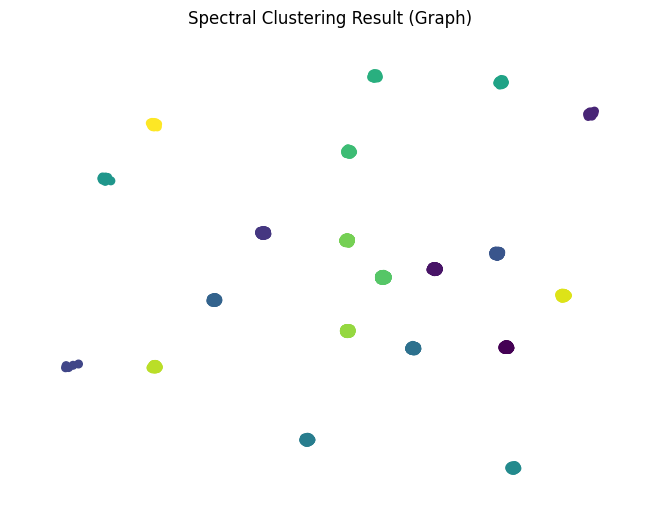

In [42]:
# Create a graph
G = nx.Graph()

# Add nodes with their respective cluster labels
for i, label in enumerate(labels_trial_updated):
    G.add_node(i, cluster=label)

# Iterate over pairs of nodes and add edges between nodes in the same cluster
for node1, data1 in G.nodes(data=True):
    for node2, data2 in G.nodes(data=True):
        if node1 < node2 and data1['cluster'] == data2['cluster']:
            G.add_edge(node1, node2)

# Visualize the graph
pos = nx.spring_layout(G)
node_colors = [data['cluster'] for node, data in G.nodes(data=True)]
nx.draw(G, pos, with_labels=False, node_size=30, node_color=node_colors, cmap='viridis', edge_color='gray')
plt.title('Spectral Clustering Result (Graph)')
plt.show()

* Recommendation start below

In [43]:
num_rows_left_testing = rest_of_the_rows_ten.groupby('Pid').size().to_dict()
num_rows_left_testing

{19: 11,
 34: 22,
 35: 24,
 207: 21,
 228: 14,
 269: 22,
 275: 16,
 298: 22,
 467: 7,
 499: 6,
 542: 11,
 601: 27,
 631: 29,
 693: 12,
 942: 48,
 1048: 5,
 1133: 15,
 1202: 39,
 1280: 6,
 1477: 3,
 1499: 17,
 1546: 17,
 1551: 4,
 1608: 5,
 1626: 65,
 1681: 15,
 1712: 31,
 1873: 9,
 1898: 21,
 2003: 84,
 2102: 16,
 2207: 5,
 2403: 27,
 2481: 9,
 2522: 8,
 2582: 16,
 2664: 39,
 2831: 18,
 3032: 36,
 3071: 27,
 3199: 13,
 3389: 8,
 3391: 11,
 3467: 9,
 3530: 18,
 3547: 33,
 3771: 22,
 3861: 17,
 4132: 6,
 4152: 32,
 4174: 34,
 4261: 8,
 4271: 45,
 4517: 15,
 4618: 8,
 4748: 61,
 4756: 31,
 4770: 10,
 4793: 13,
 5104: 22,
 5172: 8,
 5175: 8,
 5183: 81,
 5216: 13,
 5371: 27,
 5375: 11,
 5580: 19,
 5721: 7,
 5860: 3,
 5876: 26,
 5883: 2,
 5924: 6,
 6142: 6,
 6243: 12,
 6391: 6,
 6425: 2,
 6454: 40,
 6491: 66,
 6706: 23,
 6888: 35,
 6937: 30,
 6966: 14,
 7107: 28,
 7311: 73,
 7408: 15,
 7498: 33,
 7514: 9,
 8149: 58,
 8161: 28,
 8227: 12,
 8261: 29,
 8285: 2,
 8517: 17,
 8542: 9,
 8687: 25,
 

In [50]:
accuracy_dict = {}
for k, v in num_rows_left_testing.items():
    cluster = pid_label_reference_updated[k]
    pool_of_recommendation = rows_updated[rows_updated['P_Cluster'] == cluster].groupby('Pid').apply(lambda x:x)
    Pid_pool = pool_of_recommendation['Pid'].unique().tolist()
    random_pid = random.sample(Pid_pool, k=1)
    random_pid = random_pid[0]
    songs_in_random_pit = pool_of_recommendation[pool_of_recommendation['Pid'] == random_pid]
    if len(songs_in_random_pit) >=100:
        random_sample = songs_in_random_pit.sample(n=10, random_state=0)
        uri_list = random_sample['Track URI'].tolist()
        accuracy = len(rest_of_the_rows_ten[(rest_of_the_rows_ten['Track URI'].isin(uri_list)) & (rest_of_the_rows_ten['Pid'] == random_pid )])/10
        accuracy_dict[k] = accuracy

In [51]:
accuracy_dict

{}

In [46]:
average_accuracy = sum(accuracy_dict.values()) / len(accuracy_dict)
average_accuracy

ZeroDivisionError: division by zero

In [ ]:
# pool_of_recommendation = training_rows_updated[training_rows_updated['P_Cluster'] == 4].groupby('Pid').apply(lambda x:x)
# pool_of_recommendation

In [ ]:
# Pid_pool = pool_of_recommendation['Pid'].unique().tolist()
# random_pid = random.sample(Pid_pool, k=1)
# random_pid = random_pid[0]
# random_pid

In [ ]:
# songs_in_random_pit = pool_of_recommendation[pool_of_recommendation['Pid'] == random_pid]
# songs_in_random_pit

In [ ]:
# #Songs to be recommended
# random_sample = songs_in_random_pit.sample(n=10, random_state=0)
# random_sample

In [ ]:
# new_playlist